```{index} single: application; energy systems
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} network optimization
```
```{index} stochastic optimization
```
```{index} SAA
```

# Extra: Two-stage energy dispatch optimization with wind curtailment

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys
import os

if "google.colab" in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null
    SOLVER = "appsi_highs"
else:
    SOLVER = "cbc"

# Preliminaries

This notebook illustrates a two-stage stochastic optimization problem in the context of energy systems where there are recourse actions that depend on the realization of the uncertain parameters. 

The equilibrium point for the European power network, which operates on alternating current, is at a frequency of 50 Hertz with a tolerance threshold of $\pm 0.05$ Hertz. Power network operators are responsible for maintaining a constant frequency on the network. The way that operators do this is mainly by perfectly balancing power supply and demand.

But what happens if power supply does not meet demand? When _supply exceeds demand_, then the electrical frequency increases. If _demand exceeds supply_, then the frequency drops. Since power plants are designed to operate within a certain frequency range, there is a risk that they will disconnect from the grid after a period of time. If the frequency deviates too much from the 50 Hertz, then there is a risk that the power plants switch off one after another, potentially leading to a complete power blackout.

Using conventional power generators such as coal and gas, power supply and demand are often matched by increasing/decreasing the production rate of their power plants and taking generating units online or offline. With the advent of renewable energy sources, it has become increasingly more difficult to match supply and demand. Besides not being controllable power sources, network operators rely on forecasting models to predict the power generated by renewable sources. In practice, this prediction is fairly accurate for solar energy, but wind energy is particularly difficult to predict correctly. 

<img src="https://www.mdpi.com/energies/energies-13-05595/article_deploy/html/images/energies-13-05595-g018.png" width="600"/>

The goal of this notebook is to ensure that power demand meets supply while taking into account wind fluctuations. We will introduce two optimization problems and solve them as stochastic optimization problems. **Read first the [energy dispatch problem](../04/power-network.ipynb) from the Chapter 4 for the preliminaries on power networks and the Optimal Power Flow (OPF) problem**. An important difference from the setting there, is that here we *will not assume that the wind generation is a decision variable*. Instead, wind generation is a random variable, as will be explained later on. We do assume that solar and hydropower are decision variables, since the former is accurately predicated whereas the latter is controllable.

<a name="uc"></a>
## Unit Commitment

We now consider another optimization problem relevant for energy systems named the _Unit Commitment (UC)_ problem. UC is an extended version of the OPF problem in which an additional binary decision variable $x_i$ is introduced to decide whether generator $i$ should be activated or not. In this formulation we include a fixed cost $\kappa_i$ that is incurred for the activation of a generator $i$, which is also added as a new parameter `c_fixed` to the network instance. 

In practice, the UC problem is often considered as a two-stage problem. Since it takes time to activate gas and coal generators before they can produce energy, this decision must be made in advance, i.e., as here-and-now decision in the first stage. In the second stage, we then decide the power generation levels of the (activated) coal and gas generators. Note that, in particular, *we cannot produce from generators we did not already turn on!* Lastly, the UC still includes the same physical constraints as the OPF, i.e., power generation limits and line capacity constraints.

All solar and hydro generators are activated by default. Solar power is treated as deterministic in the sense that in the instance that you are given it holds that $p_{\min}=p_{\max}$ for solar generators. Hydro generators are still controllable within their nontrivial generation limits.

The uncertainty will be described in terms of the _wind speed_ $v$ instead of the wind power. To determine the wind power resulting from a given wind speed, you need to use a so-called _power curve_ $g_i(\cdot)$ for a wind generator $i$, which is an explicit function that maps the wind speed $v$ to a wind power $g_i(v)$. In the network instance that you are given, there are two wind generators, one in node 64 which is an on-shore wind park, and one in node 65 which is a off-shore wind park. Being structurally different, they have different power curves. See below a plot of the power curve function for the on-shore wind generator. 


<center><img src="onshore.png" width="700"/></center>


An analytical description of the power curves is given as follows

$$
\begin{align}
g_{64}(v) = 
\begin{cases}
0 & \text{if } v \leq 3 \\ 
0.16563 \cdot v^3 - 4.4718 & \text{if } 3 \leq v \leq 14 \\
450 & \text{if } v \geq 14
\end{cases}
\end{align}
$$

$$
\begin{align}
g_{65}(v) = 
\begin{cases}
0 & \text{if } v \leq 3.5 \\ 
0.18007 \cdot v^3 - 7.72049 & \text{if } 3.5 \leq v \leq 15 \\
600 & \text{if } v \geq 15
\end{cases}
\end{align}
$$

We now present the two-stage UC problem formulation. In the first stage, we decide which coal and gas generators to activate (all wind, solar and hydro generators are active by default). In the second stage, the exact power output of the wind parks is calculated using the power curves knowing the realization of the two wind speeds and the power outputs of the already activated generators needs to be adjusted to match demand exactly.

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in \mathcal{G}^{\text{coal}} \cup \mathcal{G}^{\text{gas}}} \kappa_i x_i + \mathbb{E}_v Q(x, v) \\
\text{s.t.} & x_i \in \{0,1\} & \forall i \in \mathcal{G}^{\text{coal}} \cup \mathcal{G}^{\text{gas}}, 
\end{array}
\end{align}
$$

where

$$
\begin{align}
\begin{array}{lllll}
Q(x,v) := &\min        & \sum_{i \in \mathcal{G}^{\text{coal}} \cup \mathcal{G}^{\text{gas}}} c_i(p_i) \\
&\text{s.t.}
& p_i = g_i(v_i) & \forall i \in \mathcal{G}^{\text{wind}}\\
&& x_i p_{i}^{\min } \leq p_{i} \leq x_i p_{i}^{\max } & \forall i \in \mathcal{G}^{\text{coal}} \cup \mathcal{G}^{\text{gas}} \\
&& p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max } & \forall i \in V \setminus (\mathcal{G}^{\text{coal}} \cup \mathcal{G}^{\text{gas}} \cup \mathcal{G}^{\text{wind}}) \\
&& \sum_{j: (i, j) \in E} f_{ij} - \sum_{j: (j, i) \in E} f_{ji} = p_i - d_i & \forall \, i \in V\\
&& f_{ij} =  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E \\
&& -f_{ij}^{max} \leq f_{ij} \leq  f_{ij}^{\max}    & \forall (i, j) \in E\\
&& \theta_i \in \mathbb{R} & \forall i \in V \\
&& f_{ij} \in \mathbb{R}                 & \forall (i, j) \in E\\
&& p_{i} \geq 0                & \forall i \in V
\end{array}
\end{align}
$$

## Package and data import

In [2]:
# Load packages
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval as make_tuple
import networkx as nx
import time

# Download the data
base_url = "https://raw.githubusercontent.com/mobook/MO-book/main/notebooks/10/"
nodes_df = pd.read_csv(base_url + "nodes.csv", index_col=0)
edges_df = pd.read_csv(base_url + "edges.csv", index_col=0)

# Read data
nodes = nodes_df.set_index("node_id").T.to_dict()
edges = edges_df.set_index(edges_df["edge_id"].apply(make_tuple)).T.to_dict()
network = {"nodes": nodes, "edges": edges}

### Network data

This notebook uses the same network as in [energy dispatch problem](../04/power-network.ipynb) and hence the same data structure. In particular, the nodes and edges of the network are stored in the `nodes` and `edges` dataframes, respectively. The `edges` dataframe contains the following columns:   
* `edge id`: the unique identifier of the edge, describing the node pair `(i,j)` of the edge;
* `f_max`: describing the maximum power flow capacity of the edge; and
* `b`: the susceptance of the edge.

In [3]:
edges_df

,edge_id,b,f_max
0,"(0, 1)",10.0100,270.705509
1,"(0, 2)",23.5849,415.734756
2,"(3, 4)",125.3133,265.273978
3,"(2, 4)",9.2593,400.159230
4,"(4, 5)",18.5185,217.852748
...,...,...,...
174,"(64, 65)",28.9059,1200.000000
175,"(67, 68)",28.9059,1200.000000
176,"(80, 79)",28.9059,1200.000000
177,"(86, 85)",4.8216,602.814908


The network includes 18 generators of different type, which is described in the `energy_type` field. We distinguish between conventional generators (coal, gas) and renewable generators (hydro, solar, wind). Every conventional generator node has two parameters:

- `c_fixed`, describing the activation cost of the conventional generators;
- `c_var`, describing the unit cost of producing energy for each conventional generator

Renewable generators are assumed to have zero marginal cost and zero activation cost. Nodes `64` and `65` correspond to the two wind generators that this notebook focuses on.

In [4]:
nodes_df

,node_id,d,p_min,p_max,c_var,is_generator,energy_type,c_fixed
0,0,44.230344,0.0,0.0,0.0,False,NaN,0.0
1,1,17.690399,0.0,0.0,0.0,False,NaN,0.0
2,2,35.514209,0.0,0.0,0.0,False,NaN,0.0
3,3,35.248977,0.0,0.0,0.0,False,NaN,0.0
4,4,0.000000,0.0,0.0,0.0,False,NaN,0.0
...,...,...,...,...,...,...,...,...
113,113,6.784856,0.0,0.0,0.0,False,NaN,0.0
114,114,19.664045,0.0,0.0,0.0,False,NaN,0.0
115,115,163.009206,0.0,0.0,0.0,False,NaN,0.0
116,116,16.175633,0.0,0.0,0.0,False,NaN,0.0


In [5]:
nodes_df[nodes_df.is_generator]

,node_id,d,p_min,p_max,c_var,is_generator,energy_type,c_fixed
9,9,0.0,0.000000,400.000000,0.0,True,hydro,0.0
11,11,0.0,0.000000,200.000000,0.0,True,hydro,0.0
24,24,0.0,0.000000,422.086431,28.0,True,coal,1689.0
25,25,0.0,0.000000,227.384370,18.0,True,coal,1057.0
30,30,0.0,0.000000,235.306239,19.0,True,coal,1837.0
45,45,0.0,0.000000,371.349675,19.0,True,coal,1456.0
48,48,0.0,227.262510,227.262510,0.0,True,solar,0.0
53,53,0.0,97.526012,97.526012,0.0,True,solar,0.0
58,58,0.0,284.753966,284.753966,0.0,True,solar,0.0
60,60,0.0,98.693808,98.693808,0.0,True,solar,0.0


Wind turbines risk to break if the wind speed is too high, so wind turbines need to be _curtailed_ (i.e., deactivated) once the wind speed exceeds a specified maximum speed $v_{\max}$. An additional second stage decision is therefore needed to decide whether to curtail the wind turbines or not. We include this additional requirement in the second-stage formulation, assuming that we have $T$ samples available.

Assume that 
  - $v_{64} \sim \text{Weibull}$ with scale parameter 15 and shape parameter 2.6.
  - $v_{65} \sim \text{Weibull}$ with scale parameter 18 and shape parameter 3.0.  

We sample $T=100$ data points from these two distributions. Using these data points, compute the average wind speeds. Then compute the objective value. Analyze the differences in the objective value and explain the differences.

Text(0, 0.5, 'Power Output')

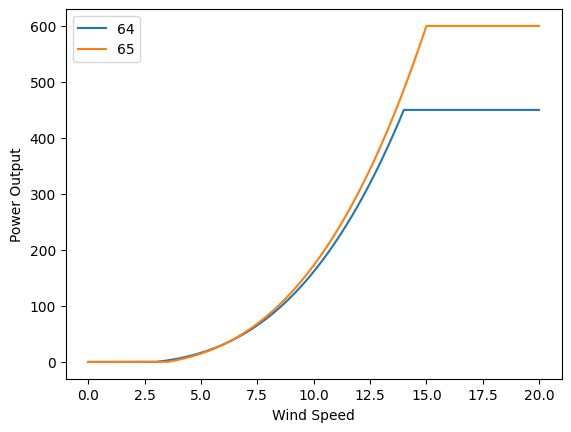

In [6]:
def g_offshore(v):
    return np.piecewise(v, [v <= 3.5, v > 15], [0, 600, lambda v: 0.18007 * v**3 - 7.72049])

def g_onshore(v):
    return np.piecewise(v, [v <= 3, v > 14], [0, 450, lambda v: 0.16563 * v**3 - 4.4718])

# assign wind generators
g = {64: g_onshore, 65: g_offshore}

# show plots
v = np.linspace(0, 20, 1000)
for i in g.keys():
    plt.plot(v, g[i](v), label=i)

plt.legend()
plt.xlabel("Wind Speed")
plt.ylabel("Power Output") 

In [7]:
def UC_windcurtailment(network, samples):
    # Maximum wind speeds for each wind generator
    vmax = {64: 20.0, 65: 22.0}

    # Define a model
    model = pyo.ConcreteModel("UC with wind curtailment")

    # Define sets
    model.T = pyo.Set(initialize=range(len(samples)))
    model.V = pyo.Set(initialize=network["nodes"].keys())
    model.E = pyo.Set(initialize=network["edges"].keys())
    model.W = pyo.Set(initialize=[i for i, data in network["nodes"].items() if data["energy_type"] == "wind"])
    
    # Set including all generator nodes except wind generators
    model.NW = pyo.Set(initialize=[i for i, data in network["nodes"].items() if data["energy_type"] != "wind"])  
    
    model.M = 1000

    # Declare decision variables
    
    # Binary variable indicating whether a generator is on or off
    model.x = pyo.Var(model.V, domain=pyo.Binary)  
    
    # Power generation of each generator
    model.p = pyo.Var(model.V, model.T, domain=pyo.NonNegativeReals) 
    
    # Voltage angle of each node
    model.theta = pyo.Var(model.V, model.T) 
    
    # Power flow on each edge
    model.f = pyo.Var(model.E, model.T, bounds=lambda m, i, j, t: (-network["edges"][(i, j)]["f_max"], network["edges"][(i, j)]["f_max"]))
    
    # Binary variable indicating whether a wind turbine is curtailed (0) or not (1)
    model.y = pyo.Var(model.W, model.T, domain=pyo.Binary)  

    # Objective function, with the goal of minimizing the total cost of generation
    @model.Expression(model.T)
    def term2(model, t):
        return sum(data["c_var"] * model.p[i, t] for i, data in network["nodes"].items() if data["is_generator"])
    
    @model.Objective(sense=pyo.minimize)
    def objective(model):
        term1 = sum(1000 * model.x[i] for i, data in network["nodes"].items() if data["energy_type"] in ["coal", "gas"])
        return term1 + sum(model.term2[t] for t in model.T) / len(model.T)

    # Declare constraints

    # Wind power output is equal to the wind speed times the wind turbine capacity, if the wind turbine is not curtailed
    @model.Constraint(model.W, model.T)
    def wind_speed_to_power(m, i, t):
        return model.p[i, t] == (1 - model.y[i, t]) * g[i](samples[t][i])
    
    @model.Constraint(model.W, model.T)
    def wind_curtailment(m, i, t):
        return samples[t][i] <= vmax[i] + model.y[i, t] * model.M

    @model.Constraint(model.NW, model.T)
    def generation_upper_bound(m, i, t):
        return m.p[i, t] <= m.x[i] * network["nodes"][i]["p_max"]
    
    @model.Constraint(model.NW, model.T)
    def generation_lower_bound(m, i, t):
        return m.p[i, t] >= m.x[i] * network["nodes"][i]["p_min"]

    # Net flow in every node must be equal to the power generation minus the demand in that node
    @model.Constraint(model.V, model.T)
    def flow_conservation(m, i, t):
        incoming_flow = sum(m.f[j, i, t] for j in model.V if (j, i) in model.E)
        outgoing_flow = sum(m.f[i, j, t] for j in model.V if (i, j) in model.E)
        return incoming_flow - outgoing_flow == m.p[i, t] - nodes[i]["d"]
    
    @model.Constraint(model.E, model.T)
    def susceptance(m, i, j, t):
        return m.f[(i, j), t] == network["edges"][(i, j)]["b"] * (m.theta[i, t] - m.theta[j, t])

    return model

We sample from two different continuous Weibull distributions with different scale and shape parameters and then solve the problem.

In [8]:
seed = 0
rng = np.random.default_rng(seed)

scale64 = 15
shape64 = 2.6
scale65 = 18
shape65 = 3

samples = [{64: scale64 * rng.weibull(shape64), 65: scale65 * rng.weibull(shape65)} for i in range(100)]

model = UC_windcurtailment(network, samples)
results = pyo.SolverFactory(SOLVER).solve(model)

print(f"Objective value: {model.objective():.2f}")
turbineactivity = np.sum([[model.y[x, t].value for x in model.W] for t in model.T], axis=0)
print(f"Number of scenarios wind tubine 64 is active: {turbineactivity[0]:2.0f} out of {len(model.T)}")
print(f"Number of scenarios wind tubine 65 is active: {turbineactivity[1]:2.0f} out of {len(model.T)}")

Objective value: 29662.84
Number of scenarios wind tubine 64 is active: 18 out of 100
Number of scenarios wind tubine 65 is active: 16 out of 100


## Assessing the quality of the solution

How can we assess the quality of the solution? For example, we could investigate how it performs compared to some baseline solution: we could have assumed 'average' values for the wind speed and solve the problem like a single-stage problem where all the data is known. That would give us some initial here-and-now commitment decisions, for which we could check in how many cases is it not even possible to schedule the production $p_i$ to meet the demand.

To do so, we need a variant of our model building function in which we can fix the initial decisions $x_i$ and seek the best possible decisions for the other variables given an observed wind speed, for each of the $T$ scenarios, and see how often is the problem infeasible. The following is a modified version of our function.

In [9]:
def UC_windcurtailment_fixed_x(network, samples, fixed_x=None):

    model = UC_windcurtailment(network, samples)
    model.G = pyo.Set(initialize=[i for i, data in network["nodes"].items() if data["is_generator"] and data["energy_type"] != "wind"])

    if fixed_x is not None:
        for i in model.G:
            model.x[i].fix(fixed_x[i]())
        
    return model

Next, we construct our average sample, solve for it, and then optimize for the second stage decisions for each of the simulated scenarios separately.

In [10]:
T = len(samples)

mean_sample = {i: np.array([samples[t][i] for t in range(T)]).mean() for i in samples[0].keys()}

m_nominal = UC_windcurtailment_fixed_x(network, [mean_sample])
pyo.SolverFactory(SOLVER).solve(m_nominal)

print(f"Nominal objective = {m_nominal.objective():0.2f}")
fixed_x = m_nominal.x

Nominal objective = 15101.25


Now, for each of our scenarios we will solve the problem by fixing the initial decisions to be the one for the 'average' scenario and see in how many of them we cannot obtain a feasible second-stage decision, which we extract using the try-except mechanism of Python catching an error in case we are trying to call a solution that does not exist.

In [11]:
import logging

# don't log pyomo warning messages
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# Variable to count the number of infeasible second stage problems
n_infeasible = 0

solver = pyo.SolverFactory(SOLVER)
for t in range(T):
    m_single = UC_windcurtailment_fixed_x(network, [samples[t]], fixed_x)
    results = solver.solve(m_single)
    n_infeasible += 1 if results.solver.termination_condition == "infeasible" else 0
 
print(f"The second stage problem is infeasible in {n_infeasible} out of {T} instances")

The second stage problem is infeasible in 65 out of 100 instances


As it turns out, the 'nominal' commitment solution would lead to infeasibility, thus a blackout, in 65% of the cases. Since a blackout is the very last thing a network operator would like to happen, this clearly demonstrates the value of the stochastic solution. It is important to note that a `very robust` solution that avoids blackouts could be explained by simply assuming very poor performance of the wind turbines. Such a solution, however, could be unnecessarily conservative and expensive, and it is therefore better to prepare for a set of `realistic` scenarios.